In [5]:
%load_ext autoreload
%autoreload 2
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import argparse
import modules.random_graph as random_graph
import logging
import modules.weight as weight
import modules.A_mat as A_mat
import modules.pramameters as pramameters
import modules.population as population
import modules.plotGraph as plotGraph
import modules.simulation as simulation
import modules.utils as utils
import modules.nn as mynn
import modules.evaluate as evaluate
import math
import pandas as pd


printFlag= 1
plotFlag= 1

#Changeable parameters 
parser = argparse.ArgumentParser(description='Topology fitting parameters')
pramameters.add_arguments(parser)
paras= pramameters.read_arguments(parser)
device= paras.device if torch.cuda.is_available() else "cpu"
#preset
paras.modelLoad= "AA"
paras.epoches= 20000
paras.strains = 3

Epi= "covid_" # sars, covid, H1N1
Epi= "" # sars, covid, H1N1

# Read the CSV file into a NumPy array
epiOData = np.genfromtxt(f'testData/{Epi}test_data.csv', delimiter=',', skip_header=0)
popData = np.genfromtxt(f'testData/{Epi}test_pop.csv', delimiter=',', skip_header=0)
popIdxData = np.genfromtxt(f'testData/{Epi}test_pop_inx.csv', delimiter=',', skip_header=0)
file_path = 'testData/Country_Population_final.csv'
data = pd.read_csv(file_path)
popName= data["Country"].tolist()
curPopName= [popName[int(i)] for i in popIdxData.tolist()]
# print(curPopName)
scaling= popData[np.argmax(popData)]/popData
print(scaling.shape)
print(epiOData.shape)
epiOData= epiOData*scaling[None, :]
epiData= epiOData.copy()/popData[np.argmax(popData)]#/popData[None, :]
epiData[1:, :]= epiData[1:, :]- epiData[:-1, :]
epiData[epiData<0]= 0
epiData= epiData.T


epiData= np.stack([epiData[:, 0:60], epiData[:, 60:120], epiData[:, 120: 180]], axis= 1)
# print(epiData.shape)
# epiData= epiData[:, None, :]
# print(epiData.shape)
divide= torch.Tensor(epiData, device= device)
# print(divide.shape)
paras.n= divide.shape[0]
P= torch.Tensor(popData, device= device)
# print(epiOData.shape)
# print(popData.shape)
# print(popIdxData.shape)
# print(len(popName))

# plt.figure(figsize=(12, 4))
# plt.plot(epiData)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(84,)
(180, 84)


torch.Size([84, 3, 60])


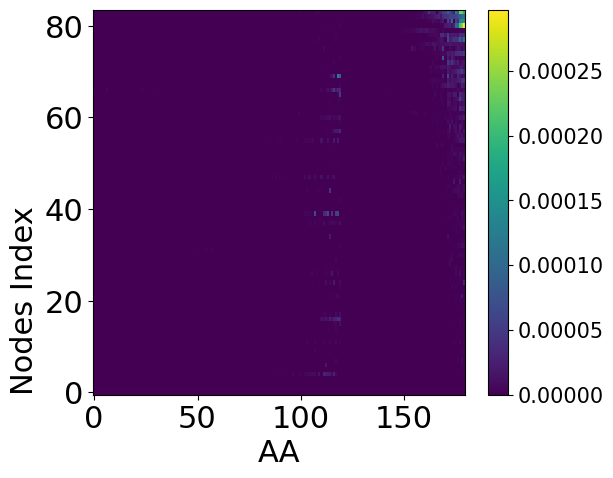

In [6]:
def rank_nodes_by_distance(G, source_node):
    # Get distances from the source_node to all other nodes
    distances = nx.single_source_shortest_path_length(G, source_node)
    # Sort nodes by distance from the source_node
    sorted_nodes = sorted(distances.items(), key=lambda x: x[1])
    # Return sorted nodes by their distance (excluding the distance values)
    return [node for node, _ in sorted_nodes]

print(divide.shape)

shapeY= divide.shape[0]
shapeX= divide.shape[1]*divide.shape[2]
divide2D= divide.reshape(shapeY, shapeX).cpu().detach()
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
fontsize= 22
cmap= ax.pcolormesh(range(shapeX), range(shapeY), divide2D)
cbar= fig.colorbar(cmap)

cbar.ax.tick_params(labelsize= fontsize-7)

plt.ylabel("Nodes Index",  loc='bottom', fontsize= fontsize)

plt.xlabel(f"{paras.modelLoad}", fontsize= fontsize)

plt.gca().axes.get_xaxis().set_visible(True)

plt.gca().axes.get_yaxis().set_visible(True)

plt.tick_params(axis='both', labelsize=fontsize)

plt.show()

In [7]:

timeHorizon= divide.shape[2]-1
if   paras.modelLoad=="AA":
    myMatch= mynn.matchingA(timeHorizon+1, paras.strains, paras.n, channel= 5,  device= device)
    myEpi= mynn.EpisA(input_dim= timeHorizon+1, num_heads= paras.strains, n= paras.n, device= device)
elif paras.modelLoad=="AsA":
    myMatch= mynn.matchingAs(timeHorizon+1, paras.strains, paras.n, channel= 5,  device= device)
    myEpi= mynn.EpisA(input_dim= timeHorizon+1, num_heads= paras.strains, n= paras.n, device= device)
elif paras.modelLoad=="AB":
    myMatch= mynn.matchingA(timeHorizon+1, paras.strains, paras.n, channel= 5,  device= device)
    myEpi= mynn.EpisB(input_dim= timeHorizon+1, num_heads= paras.strains, n= paras.n, device= device)
elif paras.modelLoad=="BA":
    myMatch= mynn.matchingB(timeHorizon+1, paras.strains, paras.n,  device= device)
    myEpi= mynn.EpisA(input_dim= timeHorizon+1, num_heads= paras.strains, n= paras.n, device= device)
elif paras.modelLoad=="BB":
    myMatch= mynn.matchingB(timeHorizon+1, paras.strains, paras.n,  device= device)
    myEpi= mynn.EpisB(input_dim= timeHorizon+1, num_heads= paras.strains, n= paras.n, device= device)
elif paras.modelLoad=="infer2018":
    myMatch= mynn.matchingB(timeHorizon+1, paras.strains, paras.n,  device= device)
    myEpi= mynn.EpisA(input_dim= timeHorizon+1, num_heads= paras.strains, n= paras.n, device= device)

    
optimizer1 = torch.optim.Adam(myMatch.parameters(),lr=3e-4)#myMatch.parameters()
optimizer2 = torch.optim.Adam({myEpi.taus},lr=3e-4)
optimizer3 = torch.optim.Adam({myEpi.R0dTaus},lr=3e-4)
myloss= torch.nn.MSELoss(reduction='sum')
losses= []
if paras.modelLoad in ["infer2018", "AB", "BB"]:
    threshold_value= 0.1
    hook = mynn.ThresholdHook(threshold_value)
    myEpi.taus.register_hook(hook)
    hook = mynn.ThresholdHook(threshold_value)
    myEpi.R0dTaus.register_hook(hook)

evaluateResults= []
PreZs= []

In [16]:
evaluateMeth= [evaluate.spectral_similarity, evaluate.pearson_correlation, evaluate.jaccard_similarity,evaluate.ROC_AUC, evaluate.PR_AUC]


for j in tqdm(range(paras.epoches)):
    optimizer1.zero_grad()
    optimizer2.zero_grad()
    optimizer3.zero_grad()
    inferZmat= myMatch(divide, paras.modelLoad)*0.2
    predSignal, signal, PreZ= myEpi(divide, inferZmat)
    loss= myloss(predSignal[:, :, 0:-1], signal[:, :, 1:])*10+ torch.var(myEpi.taus, dim= 0).sum()/1e1\
        + torch.var(myEpi.R0dTaus, dim= 0).sum()/1e1
    if torch.isnan(loss).any():
        utils.log_print(printFlag, f"meet nan value at {j}")#
        break
    losses.append(loss.item())
    loss.backward(retain_graph=True)
    optimizer1.step()
    optimizer2.step()
    optimizer3.step()

  1%|          | 157/20000 [00:08<17:29, 18.91it/s]


KeyboardInterrupt: 

In [166]:
print(torch.var(myEpi.taus, dim= 0).sum()/1e7)

tensor(1.5132e-18, grad_fn=<DivBackward0>)


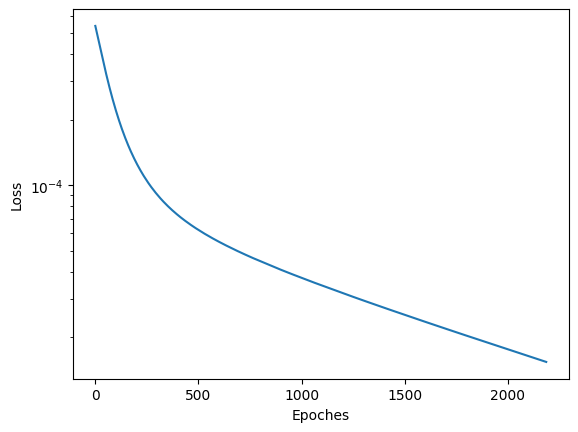

In [10]:

if plotFlag==1:
    plt.plot(losses[:])
    plt.yscale("log")
    plt.ylabel("Loss")
    plt.xlabel("Epoches")

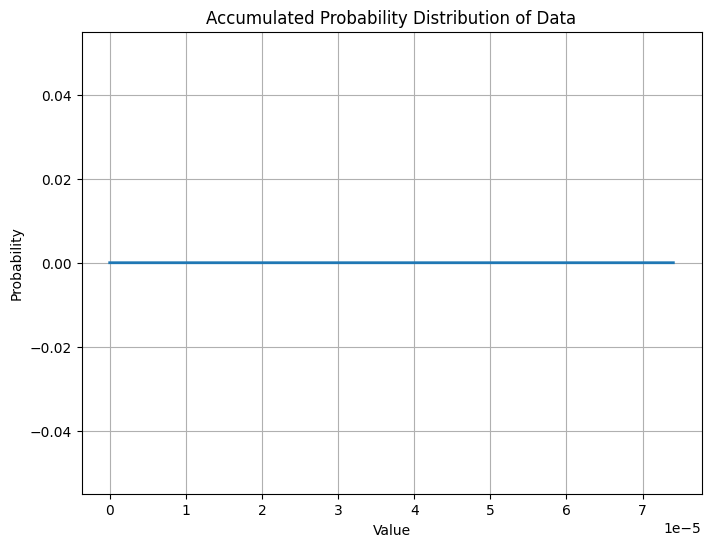

In [11]:
inferZmatNp= inferZmat.cpu().detach().numpy().squeeze()
pxs= []
pys= []
# Compute histogram
for i in range(2000):
    px= i/1000/9000/3
    py= np.sum(inferZmatNp[inferZmatNp<px])/np.sum(inferZmatNp)
    pxs.append(px)
    pys.append(py)
    pass

# Plot the histogram as a probability distribution
plt.figure(figsize=(8, 6))
plt.plot(pxs, pys, linestyle='-', linewidth=2)
plt.xlabel('Value')
plt.ylabel('Probability')
plt.title('Accumulated Probability Distribution of Data')
plt.grid(True)
plt.show()

In [13]:
printFlag= 1
# #save: A, preA, losses, taus, pretaus, R0s, preR0s, [errors]
# utils.log_print(printFlag,1/myEpi.taus.T) # recoverry rate
# utils.log_print(printFlag,(myEpi.R0dTaus).T)# transmission rate

IMatrix= torch.eye(paras.n, device= device)
# print(inferZmat)
PreA= A_mat.reverse_A_mat(inferZmat, P*0+popData[np.argmax(popData)])


utils.log_print(printFlag,torch.var(myEpi.taus, dim= 0))
utils.log_print(printFlag,torch.var(myEpi.R0dTaus, dim= 0))
startV= 5
deltaV= 7


tensor([6.1516e-12, 3.1053e-11, 2.6960e-10], grad_fn=<VarBackward0>)
tensor([1.0612e-12, 2.4329e-09, 4.5130e-08], grad_fn=<VarBackward0>)


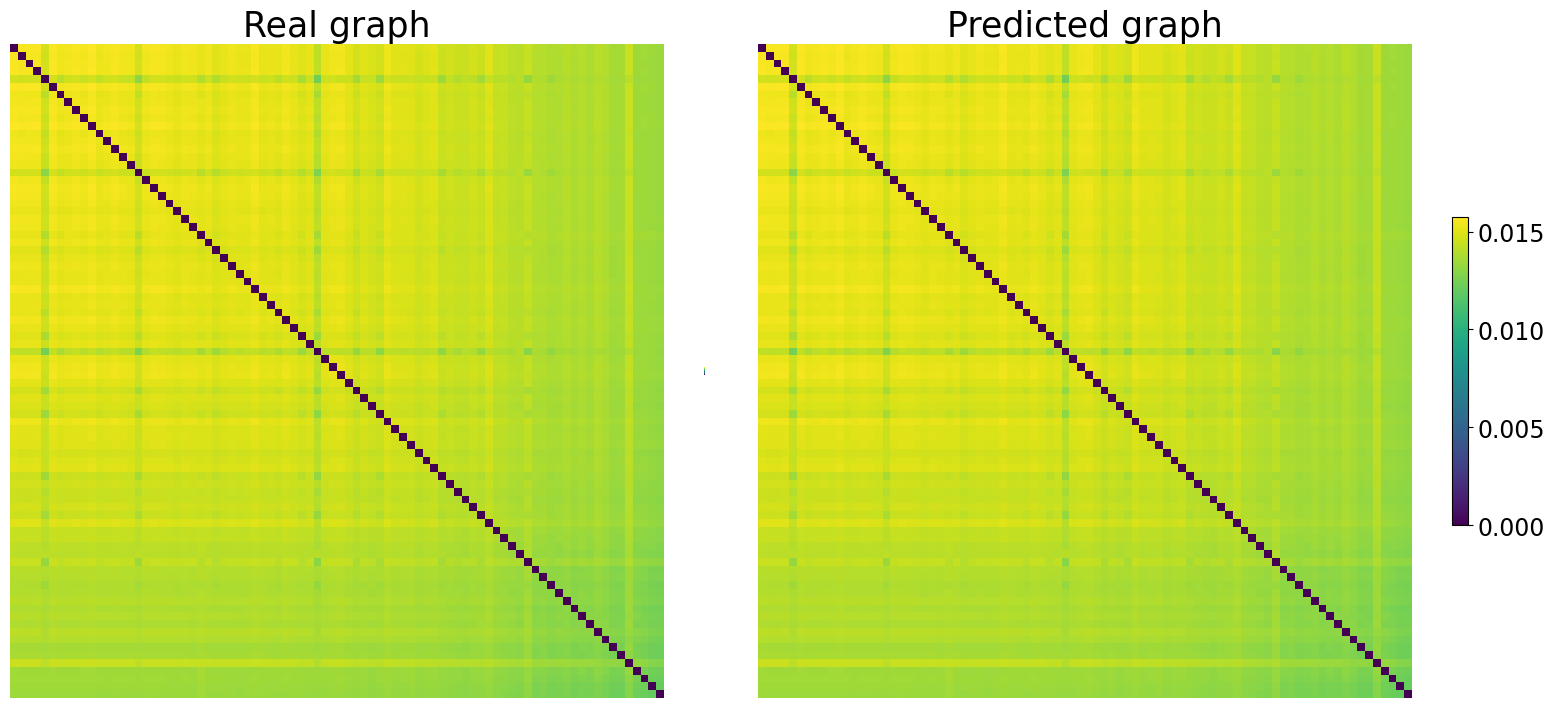

[83 82 81 80 77 78 72 74 69 70 76 73 68 67 71 75 65 64 39 62 66 63 79 60
 58 57 55  4 16 56 47 44 59 52 46 53 37 61 26 51 49 45 54 50 43 34 38 27
 40 24 32 21 36 29 33 30 11  6 28 48 15 25 23 41 20 17 14 22 12 42 35  9
  7 19 18  1  8 13 31  2  3  0  5 10]
['Iceland', 'Italy', 'Switzerland', 'Luxembourg', 'Spain', 'Norway', 'Estonia', 'Austria', 'Brunei', 'Germany', 'Iran', 'Qatar', 'Belgium', 'Slovenia', 'Sweden', 'Bahrain', 'Malta', 'Ireland', 'Chile', 'Portugal', 'Singapore', 'Finland', 'South Korea', 'Israel', 'Seychelles', 'Cyprus', 'United States', 'Canada', 'New Zealand', 'Latvia', 'Panama', 'Uruguay', 'Greece', 'Armenia', 'Greenland', 'Malaysia', 'Costa Rica', 'Kuwait', 'Barbados', 'Croatia', 'Albania', 'Slovakia', 'Maldives', 'Lebanon', 'Bosnia and Herzegovina', 'Antigua and Barbuda', 'Bulgaria', 'Denmark', 'Romania', 'Trinidad and Tobago', 'Ecuador', 'Montenegro', 'Lithuania', 'Saint Lucia', 'Serbia', 'Moldova', 'Bahamas', 'Suriname', 'Saint Vincent and the Grenadines', 'Unit

In [14]:
toShowTopology= inferZmat
if plotFlag==1:
    plotGraph.plot_adjacenty(toShowTopology.cpu().detach().numpy(), [ toShowTopology.cpu().detach().numpy()])
sumDegree= toShowTopology.cpu().detach().numpy().sum(axis= 1)
rankedPreAdegree= np.argsort(sumDegree)
print(rankedPreAdegree)
print([curPopName[i] for i in rankedPreAdegree])

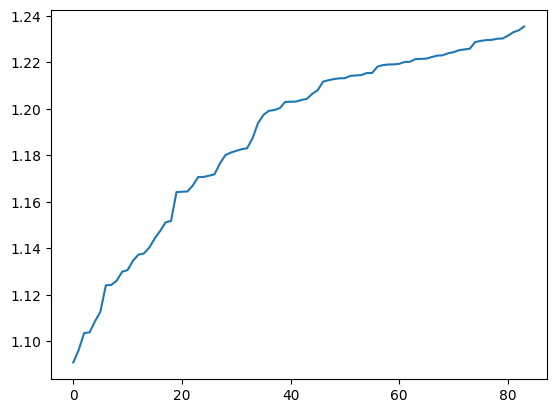

In [15]:
plt.plot(sumDegree[rankedPreAdegree])

torch.Size([150, 1, 60])


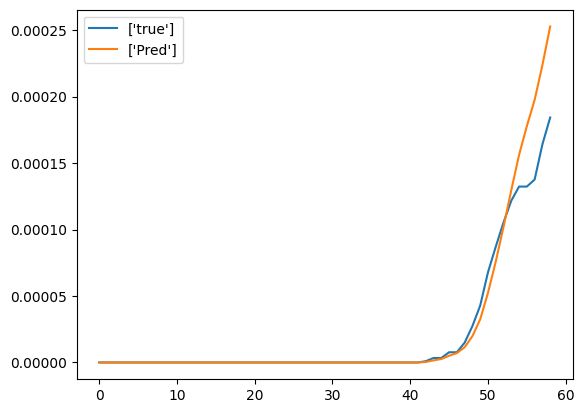

In [161]:
if plotFlag==1:
    node= [-17]
    refEpi= np.cumsum(signal[node, :, 1:].squeeze().T.cpu().detach().numpy(), axis= 0)
    preEpi= np.cumsum(predSignal[node, :, 1:].squeeze().T.cpu().detach().numpy(), axis= 0)
    plt.plot(refEpi, label= paras.strains*len(node)*["true"])
    plt.plot(preEpi, label= paras.strains*len(node)*["Pred"])
    plt.legend()
    print(signal.shape)